# Numerics
In this notebook we provide numerics associated with a paper concerning a particular Matrix Factorization problem. To be clear, the problem is given a matrix $ Y $ of dimension $ m \times N $ can we recover the dictionary $A$ and latent representation $X$ of the data under the model $Y = AX$? To make this problem tractable we assume the following,
1) $A$ is a binary matrix of dimension $m \times n$ and is the adjacency matrix of a $k, \epsilon , d$ bipartite expander graph.
2) $X$ is a sparse, real matrix whose columns are $k$ sparse (have exactly k non-zeros) and are dissociated, meaning that for any column $supp(x_i) = S$, then for any $T_1, T_2 \subset S$, $T_1 \neq T_2$, it holds that $\sum_{j \in T_1} x_{ji} \neq \sum_{j \in T_2} x_{ji} $.

In [18]:
import numpy as np
import copy
import matplotlib.pyplot as plt
from timeit import default_timer as timer

## Lemma 6 and Remark 1
In this section we provide some experimental evidence to demonstrate that the number of samples appears to be as conjectured, i.e. $N = O(\frac{n}{k}\log(n))$.

In [78]:
max_iter = 2000
num_trials = 200
n = np.arange(200, 1050, 50)
alpha = [0.1, 0.2, 0.6]

theoretical_average = np.zeros((len(alpha)+1, len(n)))

theoretical_average[0] = n*np.log(n)
for i in range(len(alpha)):
    theoretical_average[i+1] = (1/alpha[i])*np.log(n)
    
exp_av = np.zeros((len(alpha), len(n)))

# Iterate through each problem size n    
for i in range(len(n)):
    # Iterate through each value of k
    for j in range(len(alpha)):
        k = int(np.around(alpha[j]*n[i]))
        # Iterate through the number of trials we conduct for problem, i.e. fixed k and n
        for l in range(num_trials):
            # A single trial is concluded when all objects have been seen
            seen = np.zeros(n[i])
            iters = 0
            done = False
            while done == False and iters <= max_iter:
                draw = np.random.choice(n[i], k, replace=False)
                for r in range(k):
                    seen[draw[r]] = 1         
                if sum(seen) == n[i]:
                    done = True
                    exp_av[j, i] += iters
                else:
                    iters +=1
exp_av = exp_av/num_trials
    

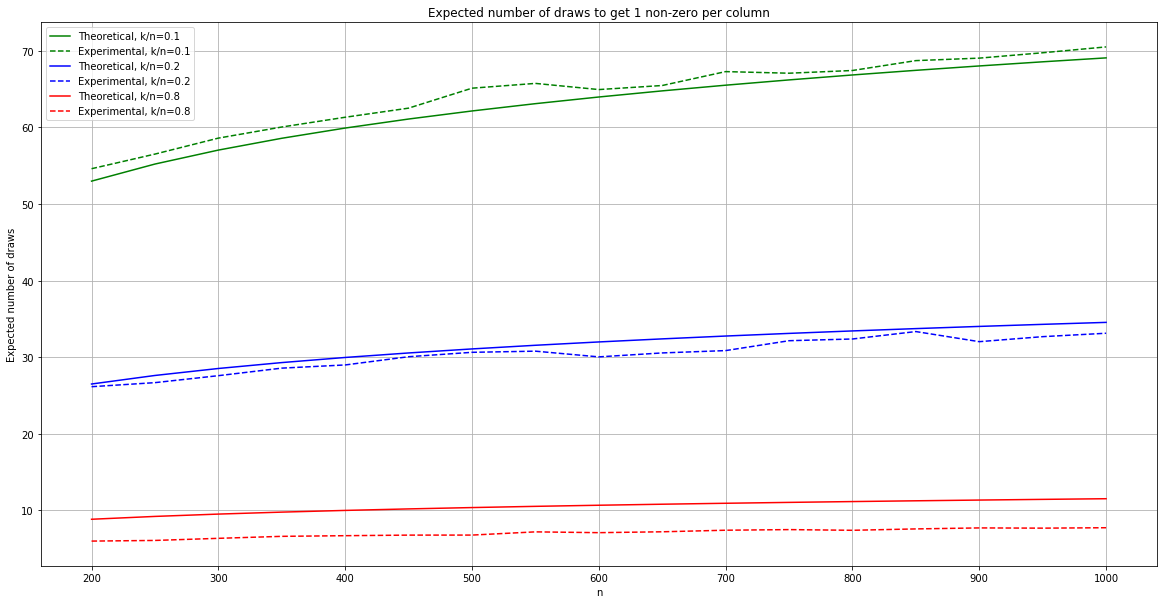

In [79]:
plt.figure(1)
plt.figure(figsize=(20,10))
# plt.plot(n, theoretical_average[0], 'k-', label="k=1")
plt.plot(n, theoretical_average[1], 'g-', label="Theoretical, k/n=%s"%(alpha_1[0]))
plt.plot(n, exp_av[0], 'g--', label="Experimental, k/n=%s"%(alpha_1[0]))
plt.plot(n, theoretical_average[2], 'b-', label="Theoretical, k/n=%s"%(alpha_1[1]))
plt.plot(n, exp_av[1], 'b--', label="Experimental, k/n=%s"%(alpha_1[1]))
plt.plot(n, theoretical_average[3], 'r-', label="Theoretical, k/n=%s"%(alpha_1[2]))
plt.plot(n, exp_av[2], 'r--', label="Experimental, k/n=%s"%(alpha_1[2]))
plt.grid(True)
plt.title('Expected number of draws to get 1 non-zero per column')
plt.xlabel('n')
plt.ylabel('Expected number of draws')
plt.legend()

## EBR Algorithm in Action
In this section we demonstrate the efficacy of EBR in action

In [ ]:
# DATA GENERATION AND PERFORMANCE CHECKING FUNCTIONS
def generate_latent(n,k,c1,c2):
    b = c2-c1
    a = c1/b
    x = np.zeros(n)
    locs = np.random.permutation(n)[:k]
    x[locs] = 1
    signs = np.sign(np.random.randn(k))
    vals = b*(np.random.rand(k)+a)
    x[locs] = x[locs]*vals*signs
    return x

def generate_exp_dictionary1(m,n,d):
    A = np.zeros((m,n))
    for i in range(n):
        locs = np.random.permutation(m)[:d]
        A[locs,i] = 1
    return A

def generate_exp_dictionary2(m,n,d):
    A = np.zeros((m,n))
    alpha = int(np.floor(m/d))
    c = 0
    while c<n:
        perm = np.random.permutation(m)
        zeta = min(n-c, alpha)
        for j in range(zeta):
            locs = perm[j*d:(j+1)*d]
            A[locs,c] = 1
            c = c+1
    return A

def check_dictionary(eps,n,d,A):
    t = (1-4*eps)*d
    mu_A = np.max(np.transpose(A)@A - d*np.identity(n))
    if mu_A >= t:
        print("Generation error, A is not expander for this value of epsilon, mu_A = ", str.format('{0:.2f}', mu_A),", tau = ", str.format('{0:.2f}', t), ".")
        passed = False
    else:
        print("A passes coherence test, mu_A = ", str.format('{0:.2f}', mu_A),", tau = ", str.format('{0:.2f}', t), ".")
        passed = True
    return passed  
        
def check_recon_A(A,A_rec,d,eps,n):
    print("Checking reconstruction of A.")
    col_sum = sum(A_rec)
    print(str.format('{0:.1f}',100*len(col_sum[col_sum==d])/n), "% of columns fully formed.")
    print(str.format('{0:.1f}',100*(n - len(col_sum[col_sum==d]) - len(col_sum[col_sum==0]))/n) , "% of columns partially formed.")
    print(str.format('{0:.1f}', 100*len(col_sum[col_sum==0])/n), "% of columns have no entries.")
    overlaps = np.transpose(A_rec)@A
    A_rec_col, A_col = np.where(overlaps>(1-4*eps)*d)
    if len(col_sum[col_sum==0])<n:
        print(str.format('{0:.1f}', 100*len(A_rec_col)/(n - len(col_sum[col_sum==0]))), "% of reconstructed (fully or partially) columns match with a column in target matrix.")  
    error = 0
    missing = 0
    P = np.zeros((n,n))
    for i in range(len(A_rec_col)):
        diff = A_rec[:, A_rec_col[i]] - A[:,A_col[i]]
        error = error + sum(abs(diff[diff==1]))
        missing = missing + sum(abs(diff[diff==-1]))
        P[A_col[i], A_rec_col[i]] = 1
    print(str.format('{0:.0f}', 100*(missing+d*n-len(A_rec_col)*d)/(d*n)), "% of entries missing in total.")
    print(str.format('{0:.0f}', missing), "entries missing in matched columns.")
    print(str.format('{0:.0f}', error), "entries wrong in matched columns.")
    return P
    
def check_recon_X(X,X_rec,P,N,k):
    X_perm = P@X_rec
    print("Checking the values of X recovered.")
    tol = 10**-6
    total_entries = N*k
    total_entries_recovered = 0
    correct_loc_correct_val = 0
    correct_loc_wrong_val = 0
    wrong_loc = 0
    missing = 0
    passed = True
    for i in range(N):
        for j in range(n):
            if abs(X[j,i])>tol and abs(X_perm[j,i])>tol:
                error = abs(X[j,i] - X_perm[j,i])
                if error < tol:
                    correct_loc_correct_val +=1
                else:
                    correct_loc_wrong_val += 1
                    print("Column number = ", i, ", row number = ", j, ", true value = ", X[j,i], "value found = ", X_perm[j,i])
            elif abs(X[j,i])>tol and abs(X_perm[j,i])<tol:
                missing += 1
            elif abs(X[j,i])<tol and abs(X_perm[j,i])>tol:
                wrong_loc += 1
    print(str.format('{0:.1f}', 100*(correct_loc_correct_val/total_entries)), "% of entries correctly recovered.")
    print(str.format('{0:.1f}', 100*(correct_loc_wrong_val/total_entries)), "% of entries in correct location but have wrong value for location.")
    print(str.format('{0:.1f}', 100*(missing/total_entries)), "% of entries missing.")
    return X_perm